# Basic Demo for D-Wave on Braket: The Minimum Vertex Cover Problem

In this tutorial we discuss both the ```BraketSampler``` and ```BraketDWaveSampler```. In essence, they are both doing the same thing; each one just accepts different parameter names. Specifically, the ```BraketDWaveSampler``` allows users familiar with D-Wave to use D-Wave parameter names, e.g., ```answer_mode```, whereas the ```BraketSampler``` parameter names are consistent with the rest of the Braket experience. 

__Minimum Vertex Cover problem__: Here we consider a well-known combinatorial optimization problem on graphs called the Minimum Vertex Cover problem. Given an undirected graph with a vertex set $V$ and an edge set $E$, a vertex cover is a subset of the vertices (nodes) such that each edge in the graph is incident to at least one vertex in the subset. The Minimum Vertex Cover problem seeks to find a cover with a minimum number of vertices in the subset.

In [1]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

__NOTE__: Please enter your S3 bucket and key below. 

In [3]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-f810698da4a5" # the name of the bucket
my_prefix = "output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [4]:
# session and device
# use the DW_2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

# or use the Advantage_system1 device with over 5000 qubits to solve larger problems
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system1")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)
Device: Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1)


## HELPER FUNCTIONS

In [5]:
# helper function to get colors for every node
def get_colors(result, n):
    """
    return list of colors=[0, 0, 1, 0, 1, 1, ...] for graph
    """
    # Obtain colors of each vertex
    colors = [0 for _ in range(n)]
    for ii in range(n):
        if ii in result:
            colors[ii] = 1
    
    return colors


In [6]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot graph with labels
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [7]:
# helper function to plot graph
def get_colored_graph(graph, pos, colors):
    """
    plot colored graph for given solution
    """
    
    # positions for all nodes
    # pos = nx.spring_layout(graph)
    
    colorlist = ['#377eb8', '#e41a1c']
    nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png


## BRAKET SAMPLER: Minimum Vertex Cover Problem

A ```sampler```, as defined [here](https://docs.ocean.dwavesys.com/en/latest/glossary.html#term-sampler) and [here](https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/samplers.html), accepts a binary quadratic model (```BQM```) and returns variable assignments. Samplers generally try to find minimizing values but can also sample from distributions defined by the ```BQM```: Samplers are processes that sample from low energy states of a problem’s objective function, which is a mathematical expression of the energy of a system. A binary quadratic model (BQM) sampler samples from low energy states in models such as those defined by an Ising equation or a QUBO problem and returns an iterable of samples, in order of increasing energy.

```BraketSampler``` is a structured sampler that uses Braket-formatted parameters and properties. For example, instead of ```answer_mode```, which is used for D-Wave QPU samplers, Braket uses ```resultFormat``` instead. Below is a sample example of solving the minimum vertex cover problem using ```BraketSampler```.

In [8]:
# set sampler
sampler = BraketSampler(s3_folder, 'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')

# EmbeddingComposite automatically maps the problem to the structure of the solver.
embedded_sampler = EmbeddingComposite(sampler)

### Minimum Vertex Cover Problem: Star Graph

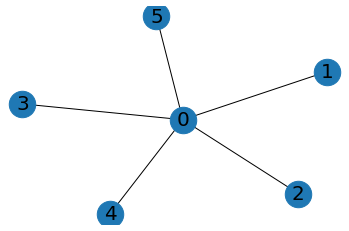

In [9]:
# set graph
n = 6
graph = nx.star_graph(n-1) 
# positions for all nodes
pos = nx.spring_layout(graph)

# plot graph with labels
get_graph(graph, pos)

In [10]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5))

In [11]:
node_number = len(graph.nodes)

In [12]:
zero_string = '0'*node_number

In [13]:
value_string_list = list()
for i in range(pow(2,node_number)):
    value_string_list.append((zero_string + bin(i)[2:])[-node_number:])

In [30]:
len(value_string_list)

64

In [14]:
color_state_map = {'0': 'blue', '1': 'red'}

In [26]:
plt.figure(figsize=(5, 5), dpi=30)

<Figure size 150x150 with 0 Axes>

<Figure size 150x150 with 0 Axes>

In [42]:
def draw_color_graph(graph, pos, index):
    plt.subplot(11,6,index)
    nx.draw(graph, node_size=1000, with_labels=True, node_color=[color_state_map[node[1]['tag']] 
                        for node in graph.nodes(data=True)])
    
    

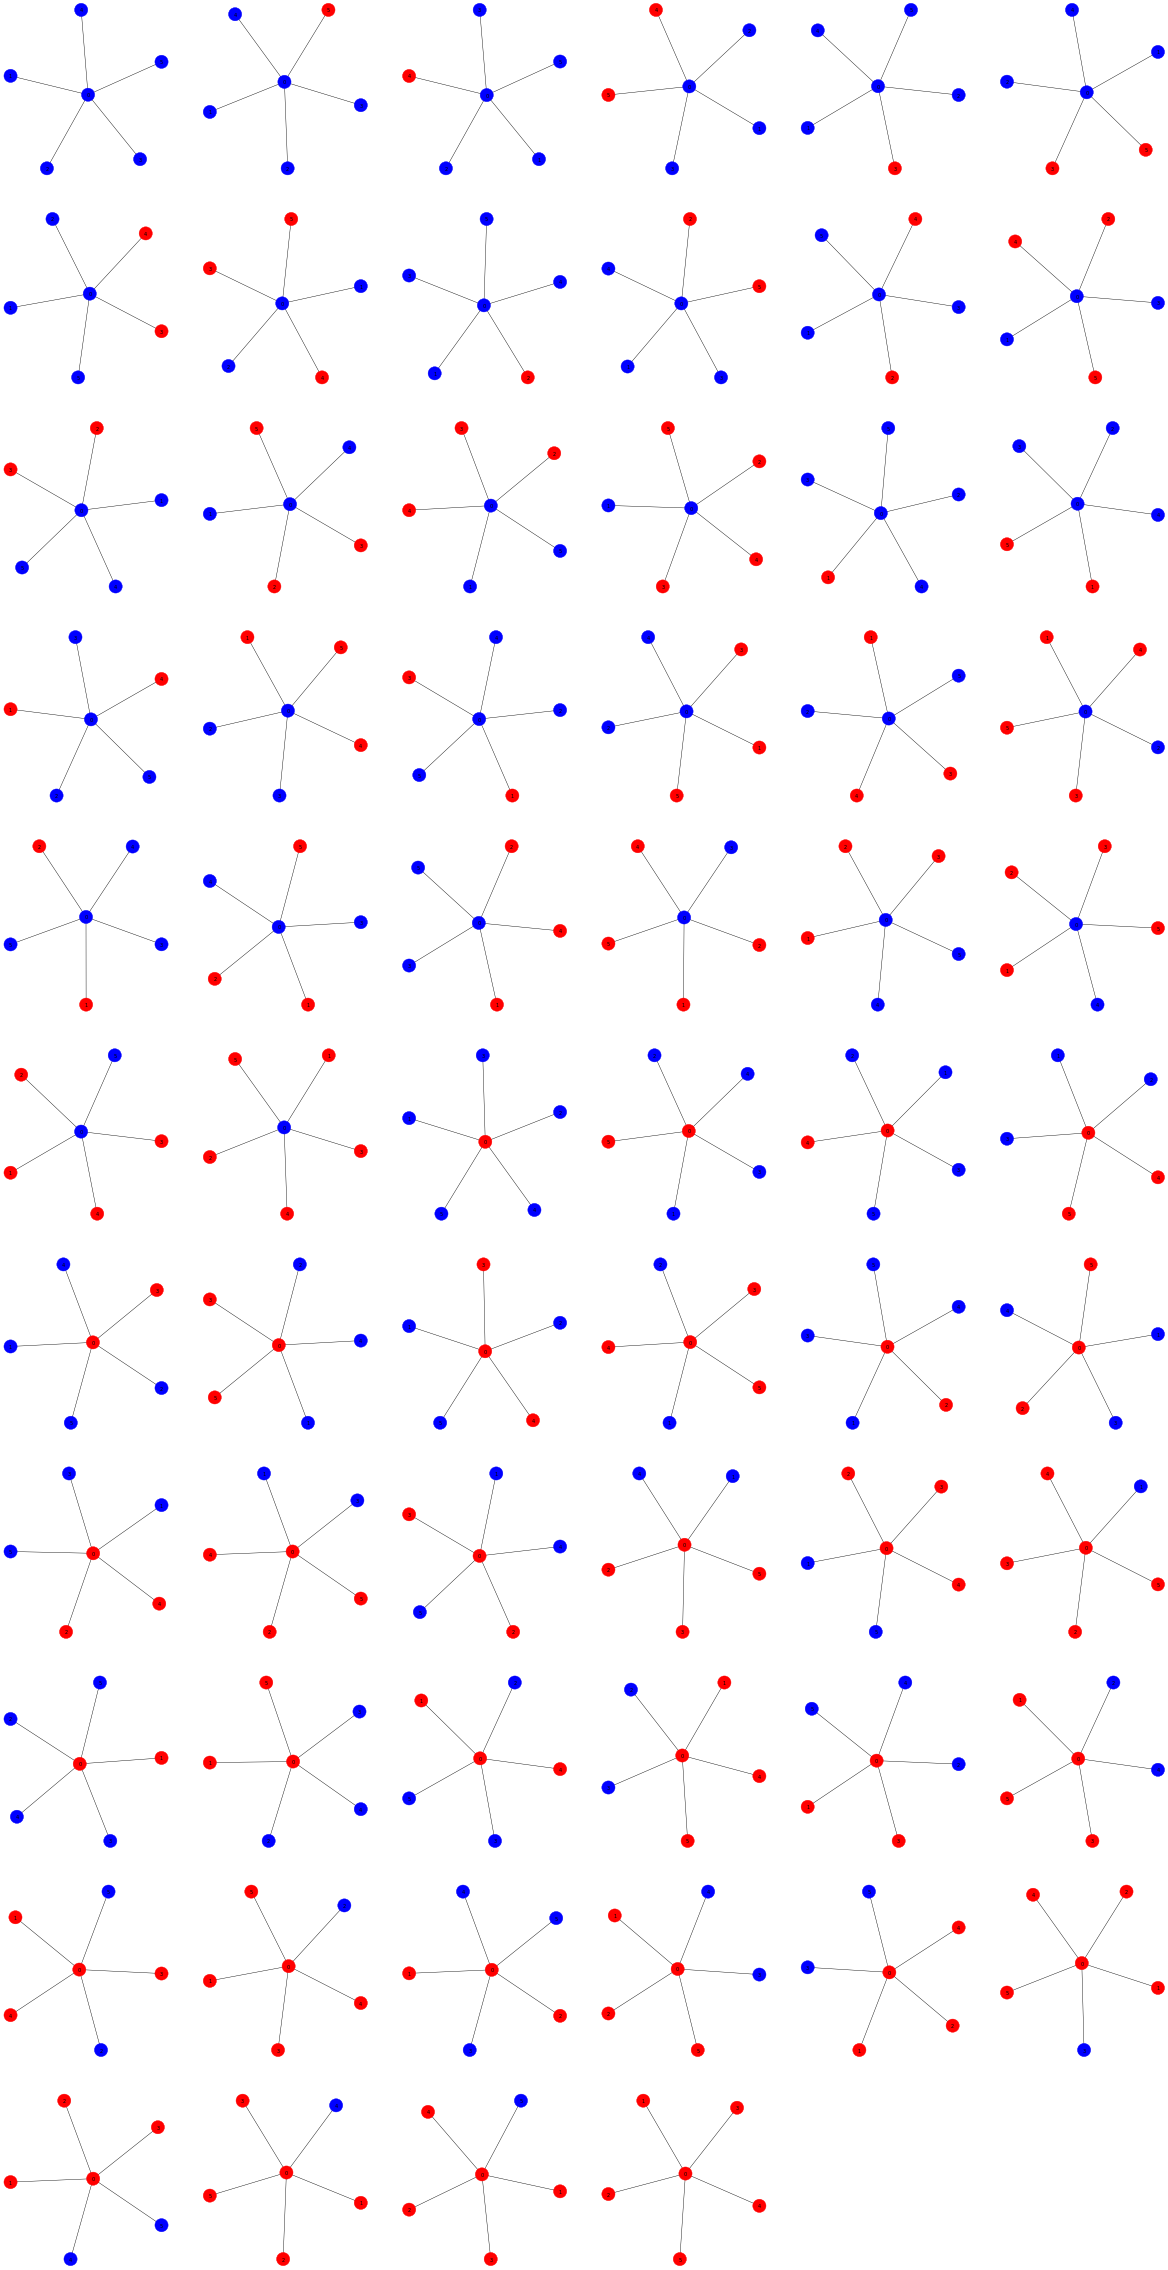

In [43]:
plt.figure(figsize=(50, 100), dpi=30)
for value_index, value_string in enumerate(value_string_list):
    for index,char in enumerate(value_string):
        bit_index = node_number - index -1
        graph.nodes()[index]['tag'] = char
        
    draw_color_graph(graph, pos, value_index+1)
    

In [50]:
enegy_value_list = list()

for value_index, value_string in enumerate(value_string_list):
    
    enegy = 0
    
#     print ('------------')
    for index,char in enumerate(value_string):
        
        if (char == '1'):
            enegy = enegy + 1
            
        bit_index = node_number - index -1
        graph.nodes()[index]['tag'] = char
        
    for u,v in graph.edges():
    
        if (graph.nodes()[u]['tag'] == '0' and graph.nodes()[v]['tag'] == '0'):
            enegy = enegy + node_number * 2
            
    enegy_value_list.append(enegy)
        
        

In [51]:
enegy_value_list

[60,
 49,
 49,
 38,
 49,
 38,
 38,
 27,
 49,
 38,
 38,
 27,
 38,
 27,
 27,
 16,
 49,
 38,
 38,
 27,
 38,
 27,
 27,
 16,
 38,
 27,
 27,
 16,
 27,
 16,
 16,
 5,
 1,
 2,
 2,
 3,
 2,
 3,
 3,
 4,
 2,
 3,
 3,
 4,
 3,
 4,
 4,
 5,
 2,
 3,
 3,
 4,
 3,
 4,
 4,
 5,
 3,
 4,
 4,
 5,
 4,
 5,
 5,
 6]

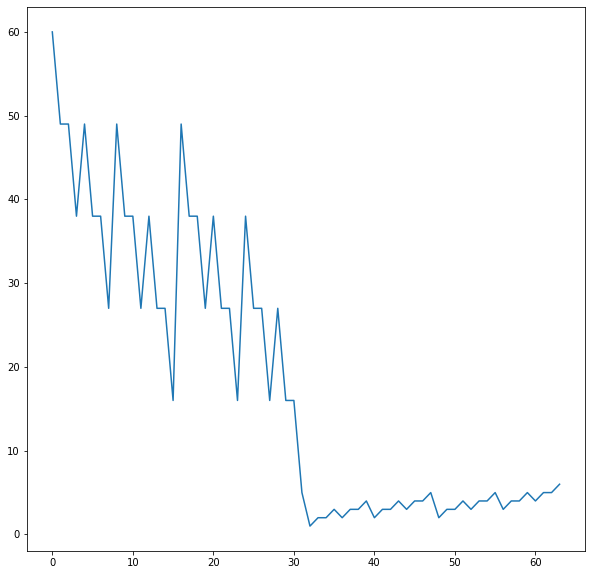

In [52]:
plt.figure(figsize=(10,10))
plt.plot(enegy_value_list)

In [45]:
for u,v in graph.edges():
    
    if graph.nodes()[u]['tag'] == '0' and graph.nodes()[u]['tag'] == '0':
        
    print ((u,v))

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)


In [17]:
for node in graph.nodes(data=True):
    print (node)

(0, {'tag': '1'})
(1, {'tag': '1'})
(2, {'tag': '1'})
(3, {'tag': '1'})
(4, {'tag': '1'})
(5, {'tag': '1'})


In [18]:
value_string_list

['000000',
 '000001',
 '000010',
 '000011',
 '000100',
 '000101',
 '000110',
 '000111',
 '001000',
 '001001',
 '001010',
 '001011',
 '001100',
 '001101',
 '001110',
 '001111',
 '010000',
 '010001',
 '010010',
 '010011',
 '010100',
 '010101',
 '010110',
 '010111',
 '011000',
 '011001',
 '011010',
 '011011',
 '011100',
 '011101',
 '011110',
 '011111',
 '100000',
 '100001',
 '100010',
 '100011',
 '100100',
 '100101',
 '100110',
 '100111',
 '101000',
 '101001',
 '101010',
 '101011',
 '101100',
 '101101',
 '101110',
 '101111',
 '110000',
 '110001',
 '110010',
 '110011',
 '110100',
 '110101',
 '110110',
 '110111',
 '111000',
 '111001',
 '111010',
 '111011',
 '111100',
 '111101',
 '111110',
 '111111']

In [19]:
graph.nodes()[0]['tag'] = 0

In [20]:
for node in graph.nodes(data=True):
    print (node)

(0, {'tag': 0})
(1, {'tag': '1'})
(2, {'tag': '1'})
(3, {'tag': '1'})
(4, {'tag': '1'})
(5, {'tag': '1'})


Result to MVC problem: [0]
Size of the vertex cover: 1


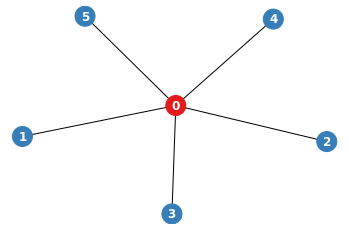

In [12]:
# run problem on D-Wave
result = dnx.min_vertex_cover(graph, embedded_sampler, resultFormat="HISTOGRAM")
print('Result to MVC problem:', result)
print('Size of the vertex cover:', len(result))

# get coloring
colors = get_colors(result, n)

# plot result
get_colored_graph(graph, pos, colors)

__Discussion__: For this specific star graph we just need one single vertex, the one at the center, to cover the entire set of edges. Clearly, this solution is the minimal vertex cover. 

### Minimum Vertex Cover Problem: Erdos Renyi graph

Let us consider a more complicated graph, from the family of random Erdoes-Renyi graphs. Such a graph can be readily generated using the ```networkx``` library. As input we set the desired number of vertices and edges connecting pairs of vertices. 

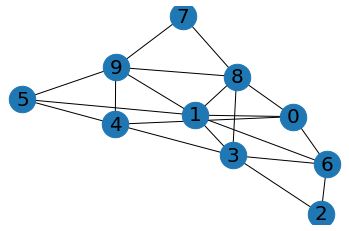

In [13]:
# setup Erdos Renyi graph
n = 10  # 10 nodes
m = 20  # 20 edges

# set graph
graph = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(graph)

# plot graph with labels
get_graph(graph, pos)

In [14]:
embedded_sampler

In [16]:
from dwave.system import DWaveSampler, EmbeddingComposite

In [20]:
h = {'a': -1., 'b': 2}
J = {('a', 'b'): 1.5}
embedded_sampler.sample_ising(h, J)

SampleSet(rec.array([([ 1, -1], -4.5, 1000, 0.)],
          dtype=[('sample', 'i1', (2,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), ['a', 'b'], {'taskMetadata': {'braketSchemaHeader': {'name': 'braket.task_result.task_metadata', 'version': '1'}, 'id': 'arn:aws:braket:us-west-2:797982941517:quantum-task/907c98d1-98b1-468a-a573-3994de434fe7', 'shots': 1000, 'deviceId': 'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6', 'deviceParameters': {'braketSchemaHeader': {'name': 'braket.device_schema.dwave.dwave_device_parameters', 'version': '1'}, 'providerLevelParameters': {'braketSchemaHeader': {'name': 'braket.device_schema.dwave.dwave_provider_level_parameters', 'version': '1'}, 'annealingOffsets': None, 'annealingSchedule': None, 'annealingDuration': None, 'autoScale': None, 'beta': None, 'chains': None, 'compensateFluxDrift': None, 'fluxBiases': None, 'initialState': None, 'maxResults': None, 'postprocessingType': None, 'programmingThermalizationDurat

In [17]:
sampler = EmbeddingComposite(DWaveSampler())
h = {'a': -1., 'b': 2}
J = {('a', 'b'): 1.5}
sampleset = sampler.sample_ising(h, J, num_reads=100)
sampleset.first.energy

ValueError: API token not defined

Result to MVC problem: [1, 3, 4, 6, 8, 9]
Size of the vertex cover: 6


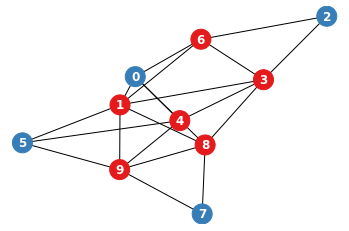

In [12]:
# run problem on D-Wave
result = dnx.min_vertex_cover(graph, embedded_sampler, resultFormat="HISTOGRAM")
print('Result to MVC problem:', result)
print('Size of the vertex cover:', len(result))

# get coloring
colors = get_colors(result, n)

# plot result
get_colored_graph(graph, pos, colors)

__Discussion__: By inspection, we can check that with the subset of blue-colored vertices we can reach every edge in the graph. This vertex cover is a subset of the vertices such that each edge in the graph is incident to at least one vertex in the subset. We have used the ```BraketSampler``` so far. Alternatively, we can use the ```BraketDWaveSampler```; this is just a matter of syntactic preferences. 

## BRAKET D-WAVE SAMPLER: Minimum Vertex Cover Problem

```BraketDWaveSampler``` is a structured sampler that uses D-Wave-formatted parameters and properties. It is interchangeable with D-Wave's ```DWaveSampler```. Only the parameter inputs to the solver need to be changed to be D-Wave formatted (e.g. ```answer_mode``` instead of ```resultFormat```).

Below is the same example as above of solving the minimum vertex cover problem. We now consider a larger problem with more nodes and edges, and solve the problem with the DWave advantage system. 

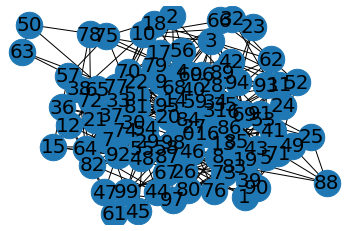

In [13]:
# setup Erdos Renyi graph
n = 100  # 100 nodes
m = 400  # 400 edges

# set graph
graph = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(graph)

# plot graph with labels
get_graph(graph, pos)

# set sampler
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/Advantage_system1')

# EmbeddingComposite automatically maps the problem to the structure of the solver.
embedded_sampler = EmbeddingComposite(sampler)

Result to MVC problem: [1, 3, 5, 6, 8, 9, 10, 11, 14, 15, 19, 20, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 39, 40, 42, 44, 45, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 62, 64, 65, 66, 68, 69, 70, 71, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 92, 93, 94, 95, 96, 97, 98, 99]
Size of the vertex cover: 67


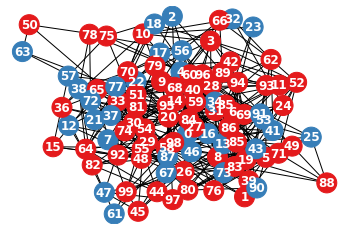

In [14]:
# run problem on D-Wave: note replacement of 'resultFormat' with 'answer_mode'
result = dnx.min_vertex_cover(graph, embedded_sampler, answer_mode="histogram")
print('Result to MVC problem:', result)
print('Size of the vertex cover:', len(result))

# get coloring
colors = get_colors(result, n)

# plot result
get_colored_graph(graph, pos, colors)

---
## APPENDIX

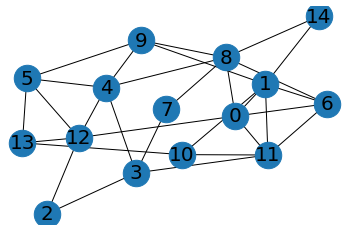

Result to MVC problem: [0, 1, 3, 4, 5, 6, 8, 10, 12]
Size of the vertex cover: 9


In [16]:
# set sampler
sampler = BraketSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')

# EmbeddingComposite automatically maps the problem to the structure of the solver.
embedded_sampler = EmbeddingComposite(sampler)

# setup Erdos Renyi graph
n = 15  # 10 nodes
m = 30  # 20 edges

# set graph
graph = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(graph)
# plot graph with labels
get_graph(graph, pos)

# The below result should be 0 because node 0 is connected to the 4 other nodes in a star graph
result = dnx.min_vertex_cover(graph, embedded_sampler, resultFormat="HISTOGRAM")
print('Result to MVC problem:', result)
print('Size of the vertex cover:', len(result))

In [17]:
# Obtain colors of each vertex
colors = [0 for _ in range(n)]
for ii in range(n):
    if ii in result:
        colors[ii] = 1

print(colors)

[1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]


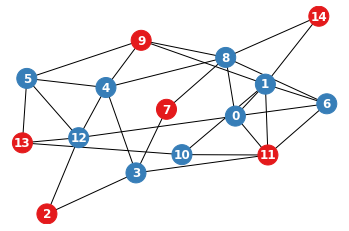

In [18]:
# plot result
get_colored_graph(graph, pos, colors)

In [19]:
print(graph.edges)

[(0, 11), (0, 6), (0, 1), (0, 8), (0, 12), (1, 10), (1, 11), (1, 9), (1, 6), (1, 14), (2, 3), (2, 12), (3, 4), (3, 11), (3, 7), (4, 9), (4, 5), (4, 12), (4, 8), (5, 12), (5, 13), (5, 9), (6, 8), (6, 11), (7, 8), (8, 14), (8, 9), (10, 11), (10, 13), (12, 13)]


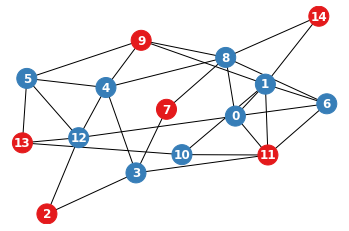

In [20]:
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                 node_size=400, font_weight='bold', font_color='w')
# plot the graph
plt.axis('off');
# plt.savefig("./figures/weighted_graph.png") # save as png
# plt.show();

### APPENDIX: Packages

Display our environmnet used for this demo. 

In [21]:
! pip freeze

# Editable install with no version control (amazon-braket-default-simulator==0.4.0)
-e /Users/xxiasos/braketvirtenv/amazon-braket-default-simulator-python/src
# Editable install with no version control (amazon-braket-ocean-plugin==0.2.0)
-e /Users/xxiasos/braketvirtenv/amazon-braket-ocean-plugin-python/src
# Editable install with no version control (amazon-braket-schemas==0.3.0)
-e /Users/xxiasos/braketvirtenv/amazon-braket-schemas-python/src
# Editable install with no version control (amazon-braket-sdk==0.6.0)
-e /Users/xxiasos/braketvirtenv/amazon-braket-sdk-python/src
appdirs==1.4.3
appnope==0.1.0
argon2-cffi==20.1.0
attrs==19.3.0
autograd==1.3
awscli==1.18.112
backcall==0.1.0
backoff==1.10.0
bleach==3.1.3
boltons==20.0.0
boto3==1.12.26
botocore==1.15.49
certifi==2019.11.28
cffi==1.14.1
chardet==3.0.4
click==7.1.1
colorama==0.4.3
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
dimod==0.9.0
distlib==0.3.0
docutils==0.15.2
dwave-cloud-client==0.7.0
dwave-hybrid==0.4.2
dwave-inspecto